# Oct 8, 2025: 3d render RSNs

conda env: pyvista-env

In [1]:
import os 
import numpy as np 
import pandas as pd
import nibabel as nib
import pyvista as pv 
import re

from glob import glob
from pathlib import Path 
import base64, io 
from PIL import Image 
import xml.etree.ElementTree as ET 

from svgutils.compose import Figure, SVG

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import colorcet as cc
import cmcrameri.cm as cmc

from itertools import chain 
import dill as pickle

from tqdm import tqdm

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()
args.SEED = 100

np.random.seed(args.SEED)

In [3]:
BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
os.makedirs(PARCELS_path, exist_ok=True)

In [4]:
args.source = 'allen'
args.space = 'ccfv2'
args.brain_div = 'whl'
args.num_rois = 172
args.resolution = 200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [5]:
TEMP_DESC = (
    f'source-allen' #f'source-{args.source}'
    f'_space-{args.space}'
    f'_res-{args.resolution}'
)
TEMP_DESC

'source-allen_space-ccfv2_res-200'

In [6]:
BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
IN_ICS_path = f'{BASE_path}/joanes_rsns'
SYS_path = f'{BASE_path}/canonical_systems/joanes/space-{args.space}'
os.system(f'mkdir -p {SYS_path}')
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
ROI_SYS_path = f'{ROI_path}/canonical-systems/joanes'
os.makedirs(f'{ROI_SYS_path}', exist_ok=True)
RSN_path = f'{ROI_SYS_path}/rsns'
os.makedirs(RSN_path, exist_ok=True)

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [8]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [9]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    num_rois = num_rois
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

In [10]:
marginal_files = sorted(glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginal_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids

In [11]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols

['pi_0_aligned',
 'pi_1_aligned',
 'pi_2_aligned',
 'pi_3_aligned',
 'pi_4_aligned',
 'pi_5_aligned',
 'pi_6_aligned',
 'pi_7_aligned',
 'pi_8_aligned']

In [12]:
marginals_df = pd.concat(
    [
        marginals_df[['sub', 'sbm', 'mode_id', 'omega']],
        marginals_df[cols],
    ],
    axis=1,
)

marginals_df

,sub,sbm,mode_id,omega,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,grp,sbm-nd-h,0,0.257972,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9496124031007752, 0.0, 0.0, 0.050387596899...","[[0.7008741858183528, 0.26384418100130885, 0.0...","[[0.9260830842147051, 0.01793128917935009, 0.0...","[[0.9921355376037768, 0.0021095634328647164, 0...","[[0.9971515016854993, 0.0001158046687140191, 0...","[[0.9972094040198562, 0.0027326936457866768, 5...","[[0.9999999999999999], [1.0], [0.9999999999999...","[[0.9999999999999999], [1.0], [0.9999999999999..."
1,grp,sbm-nd-h,1,0.141756,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9014084507042254, 0.0, 0.03521126760563380...","[[0.6443703991799266, 0.28282091773565143, 0.0...","[[0.9183218461451625, 0.037281345932509355, 0....","[[0.9818965352199229, 0.008284743540557636, 0....","[[0.9979288141148607, 0.0, 0.0, 0.002071185885...","[[0.9979288141148607, 0.0, 0.0, 0.002071185885...","[[0.9979288141148607, 0.002071185885139409], [...","[[1.0], [1.0], [1.0], [1.0], [1.00000000000000..."
2,grp,sbm-nd-h,2,0.126375,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9603174603174603, 0.0, 0.02380952380952380...","[[0.8383975812547242, 0.14635928445452254, 0.0...","[[0.9877527924750147, 0.01097694633408919, 0.0...","[[1.0], [0.9999999999999999], [1.0], [1.0], [1...","[[1.0], [0.9999999999999999], [1.0], [1.0], [1...","[[1.0], [0.9999999999999999], [1.0], [1.0], [1...","[[1.0], [0.9999999999999999], [1.0], [1.0], [1...","[[1.0], [0.9999999999999999], [1.0], [1.0], [1..."
3,grp,sbm-nd-h,3,0.121384,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8347107438016529, 0.15702479338842976, 0.0...","[[0.9265969746811219, 0.011317102226193136, 0....","[[0.9985853622217258, 0.001414637778274142], [...","[[0.9999999999999999], [1.0], [1.0], [1.0], [1...","[[0.9999999999999999], [1.0], [1.0], [1.0], [1...","[[0.9999999999999999], [1.0], [1.0], [1.0], [1...","[[0.9999999999999999], [1.0], [1.0], [1.0], [1..."
4,grp,sbm-nd-h,4,0.076945,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.974025974025974, 0.0, 0.025974025974025976...","[[0.27828425846197546, 0.6198347107438016, 0.0...","[[0.9249677407128295, 0.06439841150584952, 0.0...","[[0.9842355095437625, 0.00804980143823119, 0.0...","[[0.9914636721012164, 0.0004865264605524346, 0...","[[0.9919501985617689, 0.0, 0.0, 0.008049801438...","[[0.9919501985617689, 0.00804980143823119], [0...","[[0.9919501985617689, 0.00804980143823119], [0..."
5,grp,sbm-nd-h,5,0.071034,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6619718309859155, 0.18309859154929578, 0.1...","[[0.7930815463748849, 0.1746990704773743, 0.00...","[[0.9652913543523256, 0.009194687919861805, 0....","[[0.9978842450147893, 0.0, 0.00211575498521052...","[[0.9999999999999999], [1.0000000000000002], [...","[[0.9999999999999999], [1.0000000000000002], [...","[[0.9999999999999999], [1.0000000000000002], [...","[[0.9999999999999999], [1.0000000000000002], [..."
6,grp,sbm-nd-h,6,0.056213,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.7321428571428571, 0.0, 0.05357142857142857...","[[0.5482214214357072, 0.38371628371628375, 0.0...","[[0.9334330210605721, 0.02740830597973455, 0.0...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1..."
7,grp,sbm-nd-h,7,0.035825,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9722222222222222, 0.0, 0.02777777777777777...","[[0.7021384479717813, 0.29786155202821873, 0.0...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0....","[[1.0], [1.

In [13]:
template_file = f'{PARCELS_path}/{TEMP_DESC}_desc-template.nii.gz'

In [14]:
parcels_file = f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz'
# parcels_img = nib.load(parcels_file)

try:
    roi_table = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')
    roi_labels = roi_table['roi'].to_numpy()
except:
    roi_labels = np.arange(1, args.num_rois+1)

In [15]:
roi_rsns_mat = np.loadtxt(f'{ROI_SYS_path}/desc-roi-rsns-mat.csv')
roi_rsns_mat

array([[0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], shape=(172, 6))

In [16]:
rsn_files = sorted(glob(f'{RSN_path}/*'))

rsns_df = []
for rsn_file in rsn_files:
    match = re.search(r'name-([^_]+)_desc-(\d+)', rsn_file)
    if match:
        name, num = match.groups()
    img = nib.load(rsn_file)
    row = pd.DataFrame(dict(
        name=[name],
        num=[num],
        img=[img],
    ))
    # break
    rsns_df += [row]
rsns_df = pd.concat(rsns_df).sort_values(by='num').reset_index(drop=True)
rsns_df

,name,num,img
0,somatosensory,00,\n<class 'nibabel.nifti1.Nifti1Image'>\ndata s...
1,sensory,01,\n<class 'nibabel.nifti1.Nifti1Image'>\ndata s...
2,olfactory,02,\n<class 'nibabel.nifti1.Nifti1Image'>\ndata s...
3,limbic,03,\n<class 'nibabel.nifti1.Nifti1Image'>\ndata s...
4,basal ganglia,04,\n<class 'nibabel.nifti1.Nifti1Image'>\ndata s...
5,cerebellar,05,\n<class 'nibabel.nifti1.Nifti1Image'>\ndata s...


In [17]:
def pad_volume(vol, spacing, pad=(4,4,4), origin=(0,0,0), name="scalars"):
    (sx, sy, sz) = spacing
    px, py, pz = pad 
    padw = ((px, px), (py, py), (pz, pz))
    vol_p = np.pad(vol, padw, mode="constant", constant_values=0)
    ox, oy, oz = origin
    origin_p = (ox - px*sx, oy - py*sy, oz - pz*sz)
    
    g = pv.ImageData()
    g.dimensions = vol_p.shape
    g.spacing    = spacing
    g.origin     = origin_p
    g.point_data[name] = vol_p.reshape(-1, order="F")
    return g

def make_shell(grid: pv.ImageData, iso=0.5, sample_rate=2.0, smooth_iters=100, decimate=0.5):
    g = grid
    g = g.resample(sample_rate=sample_rate)
    shell = g.contour([iso], method='marching_cubes').smooth_taubin(n_iter=smooth_iters)
    if decimate is not None and 0.0 < decimate < 1.0:
        shell = shell.decimate(decimate)
    return shell

In [18]:
def select_rois(roi_df, hemi='B'):
    if hemi == 'B':
        return roi_df
    else:
        return roi_df[roi_df['hemi'] == hemi].reset_index(drop=True)

In [19]:
def plot_view(p: pv.Plotter, idx, cam_args=dict(), comm_rois_df=dict(), rsn_rois_df=dict()):
    hemi = views_df.at[idx, 'hemi']
    underlay_mesh = template_df[template_df['hemi'] == hemi]['mesh'].to_list()[0]
    comm_rois_df = select_rois(comm_rois_df, hemi)
    rsn_rois_df = select_rois(rsn_rois_df, hemi)
    
    # add_RIA_axes(p)
    
    p.add_mesh(
        underlay_mesh,
        color='#cccccc', opacity=0.18, smooth_shading=True,
    )
    
    for idx_, row in rsn_rois_df.iterrows():
        roi, hemi, roi_mesh, color = row
        p.add_mesh(
            roi_mesh, 
            color=color,
            opacity=0.7, 
            smooth_shading=True,
        )
    
    for idx_, row in comm_rois_df.iterrows():
        roi, hemi, roi_mesh, color = row
        p.add_mesh(
            roi_mesh, 
            color=color,
            opacity=0.7, 
            smooth_shading=True,
        )
        
    p.camera_position = cam_args['pos']
    p.camera.roll = cam_args['roll']
    p.camera.azimuth = cam_args['a']
    p.camera.elevation = cam_args['e']
    
    return p

In [20]:
def single_view(idx, folder, camera_args, comm_rois_df, rsn_rois_df):
    ncols = 1
    nrows = 1
    w = 20 / 9 # points
    h = w
    p = pv.Plotter(
        shape=(nrows, ncols),
        # window_size=(ncols*w, nrows*h), 
        off_screen=True, 
        border=False,
    )
    # p.enable_parallel_projection() # identical scale in every subplot
    p.set_background('white')

    camera_args['a'] = 45 * idx
    p = plot_view(p, idx, camera_args, comm_rois_df, rsn_rois_df)
    
    p.save_graphic(f'{folder}/scene_{idx}.svg')
    p.export_html(f'{folder}/scene.html')

In [21]:
# cropping + tightening images

In [22]:
# chatgpt gave this cell
SVG_NS = 'http://www.w3.org/2000/svg'
XLINK_NS = 'http://www.w3.org/1999/xlink'
ET.register_namespace('', SVG_NS)
ET.register_namespace('xlink', XLINK_NS)

def _get_image_elem(root):
    # Return the first <image> element
    return root.find(f".//{{{SVG_NS}}}image")

def _load_rgba_from_href(svg_path, href):
    if href.startswith("data:image"):
        b64 = href.split(",", 1)[1]
        return Image.open(io.BytesIO(base64.b64decode(b64))).convert("RGBA")
    # relative/absolute file path
    p = Path(href)
    if not p.exists():
        p = (Path(svg_path).parent / href).resolve()
    return Image.open(p).convert("RGBA")

def _crop_white(im, white_threshold=245, pad_px=0):
    a = np.array(im)
    rgb, alpha = a[..., :3], a[..., 3]
    near_white = (rgb >= white_threshold).all(axis=-1)
    a[..., 3] = np.where(near_white, 0, alpha)   # make near-white transparent
    alpha2 = a[..., 3]
    ys, xs = np.where(alpha2 > 0)
    if xs.size == 0:  # nothing found: return original
        return Image.fromarray(a, "RGBA")
    x0, x1 = max(0, xs.min()-pad_px), min(im.width,  xs.max()+1+pad_px)
    y0, y1 = max(0, ys.min()-pad_px), min(im.height, ys.max()+1+pad_px)
    return Image.fromarray(a, "RGBA").crop((x0, y0, x1, y1))

def _write_tight_svg(out_path, pil_rgba):
    buf = io.BytesIO()
    pil_rgba.save(buf, format="PNG")
    data_uri = "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")
    svg = ET.Element(f"{{{SVG_NS}}}svg", {
        "version":"1.1",
        "width":  f"{pil_rgba.width}px",
        "height": f"{pil_rgba.height}px",
        "viewBox": f"0 0 {pil_rgba.width} {pil_rgba.height}",
    })
    ET.SubElement(svg, f"{{{SVG_NS}}}image", {
        f"{{{XLINK_NS}}}href": data_uri,
        "x":"0", "y":"0",
        "width": str(pil_rgba.width),
        "height":str(pil_rgba.height),
        "preserveAspectRatio":"none",
    })
    ET.ElementTree(svg).write(out_path, encoding="utf-8", xml_declaration=True)
    
def trim_svg(svg_in, svg_out=None, white_threshold=245, pad_px=0):
    """Read SVG, crop embedded raster to remove white margins, write tight SVG."""
    svg_in = Path(svg_in)
    if svg_out is None:
        svg_out = svg_in.with_suffix("").with_name(svg_in.stem + "_cropped").with_suffix(".svg")
    root = ET.parse(svg_in).getroot()
    img = _get_image_elem(root)
    if img is None:
        raise RuntimeError("No <image> element found (this expects an SVG that wraps a raster).")
    href = img.get(f"{{{XLINK_NS}}}href") or img.get("href")
    if not href:
        raise RuntimeError("No href on <image> (neither xlink:href nor href).")
    im = _load_rgba_from_href(svg_in, href)
    cropped = _crop_white(im, white_threshold=white_threshold, pad_px=pad_px)
    _write_tight_svg(svg_out, cropped)
    return str(svg_out), (cropped.width, cropped.height)

In [23]:
# montage individual views

In [24]:
def montage_scenes(folder, sizes):
    slots = [(1,2), (2,2), (2,1), (2,0), (1,0), (0,0), (0,1), (0,2)]
    
    Ws = np.zeros((3, 3))
    Hs = np.zeros((3, 3))

    for idx in range(8):
        w, h = sizes[idx]
        r, c = slots[idx]
        Ws[r, c] = w 
        Hs[r, c] = h

    # total size of image
    W = np.sum(Ws, axis=1).max() # total width of image
    H = np.sum(Hs, axis=0).max() # total height of image
    
    # positions of each panel
    Xs = np.zeros((3, 3))
    for i in range(3):
        Xs[i,0] = 0
        Xs[i,1] = Ws[i,0]
        Xs[i,2] = W - Ws[i,2]

    Ys = np.zeros((3, 3))
    for j in range(3):
        Ys[0,j] = 0
        Ys[1,j] = Hs[0,j]
        Ys[2,j] = H - Hs[2,j]
        
    elems = [SVG(f'{folder}/scene_{i}_cropped.svg').move(Xs[r,c], Ys[r,c])
            for i,(r,c) in enumerate(slots)]
    Figure(f"{W}px", f"{H}px", *elems).save(f'{folder}/montage.svg')

In [25]:
pad_vox = (4, 4, 4) # padding to avoid open ends (olfactory/cerebellum)

In [26]:
img = nib.load(template_file)
template_vol = img.get_fdata()[::-1, :, :]
spacing = img.header.get_zooms()[:3]
template_grid = pad_volume(
    template_vol, 
    spacing, pad=pad_vox, 
    origin=(0, 0, 0), name='template'
)
template_mesh = make_shell(
    template_grid, 
    iso=30, sample_rate=1, 
    smooth_iters=75
)

In [27]:
x0 = 0.5*(template_mesh.bounds[0] + template_mesh.bounds[1])
y0 = 0.5*(template_mesh.bounds[2] + template_mesh.bounds[3])
z0 = 0.5*(template_mesh.bounds[4] + template_mesh.bounds[5])
MID_ORIGIN = (x0, y0, z0)

right_temp_mesh = template_mesh.clip(normal=(-1,0,0), origin=MID_ORIGIN).triangulate().clean()  # keeps x >= x0
left_temp_mesh = template_mesh.clip(normal=( 1,0,0), origin=MID_ORIGIN).triangulate().clean()  # keeps x <= x0
right_temp_mesh = right_temp_mesh.fill_holes(50).clean()
left_temp_mesh = left_temp_mesh.fill_holes(50).clean()

In [28]:
template_df = pd.DataFrame(dict(
    hemi=['L', 'R', 'B'],
    mesh=[left_temp_mesh, right_temp_mesh, template_mesh],
))
template_df

,hemi,mesh
0,L,PolyData (0x7fb44eb77ca0)\n N Cells: 12307...
1,R,PolyData (0x7fb44eb77d00)\n N Cells: 12383...
2,B,PolyData (0x7fb44eb77c40)\n N Cells: 22518...


In [29]:
camera_args = dict(
    pos='yz',
    roll=180,
    a=0, # update azimuth here for each view
    e=35,
)

views_df = pd.DataFrame(dict(
    idx=[0, 1, 2, 3, 4, 5, 6, 7],
    hemi=['L', 'B', 'B', 'B', 'R', 'B', 'B', 'B']
))
views_df

,idx,hemi
0,0,L
1,1,B
2,2,B
3,3,B
4,4,R
5,5,B
6,6,B
7,7,B


In [30]:
parcels_img = nib.load(parcels_file)
parcels_vol = parcels_img.get_fdata()[::-1, :, :]
spacing = parcels_img.header.get_zooms()[:3]

In [31]:
def get_rois_df(args, comm, roi_vector, roi_labels, parcels_vol):
    rois_df = []
    for idx_roi, (roi_label, membership) in enumerate(zip(roi_labels, roi_vector)):
        if membership < args.thresh: continue
        roi_vol = (parcels_vol == roi_label).astype(int)
        roi_grid = pad_volume(roi_vol, spacing, pad=pad_vox, origin=(0, 0, 0), name=f'roi-{roi_label:03d}')
        roi_mesh = make_shell(roi_grid, sample_rate=1, smooth_iters=150)
        row = {
            'roi': roi_label,
            'hemi': 'R' if roi_label <= args.num_rois / 2 else 'L',
            'mesh': roi_mesh,
            'color': args.cmap(norm(membership))[:3], #'#D55E00'
        }
        rois_df += [row]
    rois_df = pd.DataFrame(rois_df)#.sort_values('roi').reset_index(drop=True)
    return rois_df

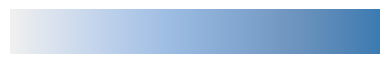

In [32]:
args.thresh = 0.1

norm = Normalize(vmin=0, vmax=1)
args.cmap = cc.cm.CET_L12 #cmc.batlow #

gradient = np.linspace(0, 1, 256).reshape(1, -1)
cmap_fig, ax = plt.subplots(figsize=(4, 0.75))
ax.imshow(gradient, aspect='auto', cmap=args.cmap)
ax.set_axis_off()
plt.tight_layout()

In [33]:
pi = marginals_df.at[0, cols[1]]
idx_comm = 1-1
roi_vector = pi[:, idx_comm]
comm_rois_df = get_rois_df(args, idx_comm, roi_vector, roi_labels, parcels_vol)
comm_rois_df

,roi,hemi,mesh,color
0,1,R,PolyData (0x7fb44ea52320)\n N Cells: 190\n...,"(0.28061, 0.50422, 0.70647)"
1,30,R,PolyData (0x7fb44ea517e0)\n N Cells: 308\n...,"(0.28061, 0.50422, 0.70647)"
2,31,R,PolyData (0x7fb44ea52140)\n N Cells: 110\n...,"(0.28061, 0.50422, 0.70647)"
3,32,R,PolyData (0x7fb44ea51ea0)\n N Cells: 308\n...,"(0.2845, 0.50587, 0.70724)"
4,33,R,PolyData (0x7fb44ea52440)\n N Cells: 214\n...,"(0.28061, 0.50422, 0.70647)"
5,34,R,PolyData (0x7fb44ea523e0)\n N Cells: 258\n...,"(0.28061, 0.50422, 0.70647)"
6,44,R,PolyData (0x7fb44ea51a80)\n N Cells: 868\n...,"(0.23431, 0.48601, 0.69831)"
7,45,R,PolyData (0x7fb44ea51de0)\n N Cells: 122\n...,"(0.28061, 0.50422, 0.70647)"
8,47,R,PolyData (0x7fb44ea51cc0)\n N Cells: 232\n...,"(0.23431, 0.48601, 0.69831)"
9,48,R,PolyData (0x7fb44ea512a0)\n N Cells: 68\n ...,"(0.28061, 0.50422, 0.70647)"


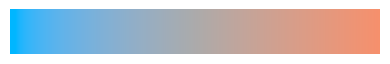

In [34]:
args.thresh = 0.1

norm = Normalize(vmin=0, vmax=1)
args.cmap = cc.cm.CET_D11 #cc.cm.CET_L12 #cmc.batlow #

gradient = np.linspace(0, 1, 256).reshape(1, -1)
cmap_fig, ax = plt.subplots(figsize=(4, 0.75))
ax.imshow(gradient, aspect='auto', cmap=args.cmap)
ax.set_axis_off()
plt.tight_layout()

In [35]:
idx_rsn = 3-1
roi_vector = roi_rsns_mat[:, idx_rsn]
rsn_rois_df = get_rois_df(args, idx_rsn, roi_vector, roi_labels, parcels_vol)
rsn_rois_df

,roi,hemi,mesh,color
0,1,R,PolyData (0x7fb44e8d6380)\n N Cells: 190\n...,"(0.96644, 0.56505, 0.42674)"
1,30,R,PolyData (0x7fb44e8d6f20)\n N Cells: 308\n...,"(0.96644, 0.56505, 0.42674)"
2,31,R,PolyData (0x7fb44e8d71c0)\n N Cells: 110\n...,"(0.96644, 0.56505, 0.42674)"
3,32,R,PolyData (0x7fb44e8d7460)\n N Cells: 308\n...,"(0.96644, 0.56505, 0.42674)"
4,33,R,PolyData (0x7fb44e8d6e60)\n N Cells: 214\n...,"(0.96644, 0.56505, 0.42674)"
5,34,R,PolyData (0x7fb44e8d76a0)\n N Cells: 258\n...,"(0.96644, 0.56505, 0.42674)"
6,35,R,PolyData (0x7fb44e8d7160)\n N Cells: 446\n...,"(0.96644, 0.56505, 0.42674)"
7,36,R,PolyData (0x7fb44e8d6e00)\n N Cells: 248\n...,"(0.96644, 0.56505, 0.42674)"
8,37,R,PolyData (0x7fb44e8d6260)\n N Cells: 254\n...,"(0.96644, 0.56505, 0.42674)"
9,44,R,PolyData (0x7fb44e8d7340)\n N Cells: 868\n...,"(0.96644, 0.56505, 0.42674)"


In [36]:
out_folder = (
    f'{ESTIM_path}/group/resemblance-to-rsns'
        f'/{SBM}'
        f'/rsn-comm-intersection-intuition'
)
os.makedirs(out_folder, exist_ok=True)

# render views
for _, view_row in views_df.iterrows():
    idx = view_row['idx']
    single_view(idx, out_folder, camera_args, comm_rois_df, rsn_rois_df)

# arrange views
pad = 10 #px
sizes = []
for svg_in in sorted(glob(f'{out_folder}/scene_?.svg')):
    svg_out, size = trim_svg(svg_in)
    sizes += [(size[0]+pad, size[1]+pad)]
montage_scenes(out_folder, sizes)

2025-10-10 20:56:32.182 (   4.330s) [    7FB53E0F6740]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/card1: Permission denied

2025-10-10 20:56:32.184 (   4.333s) [    7FB53E0F6740] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x56261c05d5e0): EGL device index: 0 could not be initialized. Trying other devices...
libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/card0: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/card1: Permission denied

2025-10-10 20:56:32.210 (   4.358s) [    7FB53E0F6740] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x56261bde2fb0): EGL device index: 0 could not be initialized. Trying other devices...
libEGL warning: failed to open /dev/dri/renderD128: Permission denied

